In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

#fetching data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

### Data pre-processing

In [4]:
underlying = '600789.SS'#鲁抗医药600789.SS
st = '2009-01-01'
et = '2019-01-01'

data = pdr.get_data_yahoo(underlying,st,et)
data = data.dropna()
data = data .iloc[:,:4]

data['S_10'] = data['Close'].rolling(window=10).mean()
data['Corr'] = data['Close'].rolling(window=10).corr(data['S_10'])
data['RSI'] = ta.RSI(np.array(data['Close']), timeperiod =10)
data['Open-Close'] = data['Open'] -data['Close'].shift(1) #shift(1)向后移动， shift(-1)向前移动  今天-昨天
data['Open-Open'] = data['Open'] - data['Open'].shift(1) #今天的open - 昨天的open

data =data .dropna()
factors =data .columns[:9]

print(data.head())
print('factors:',factors)


X = data[factors]
y = np.where(data['Close'].shift(-1) > data['Close'],1,-1)  #明天涨跌情况 作为今天的数据


[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close      S_10      Corr        RSI  \
Date                                                                            
2009-02-05  3.10769  3.13846  3.00000  3.03846  3.002308  0.784725  62.061980   
2009-02-06  3.03077  3.16923  3.03077  3.14615  3.030769  0.784804  68.040088   
2009-02-09  3.16154  3.26923  3.10000  3.24615  3.069999  0.816358  72.509524   
2009-02-10  3.22308  3.29231  3.16923  3.28462  3.094615  0.906136  74.060109   
2009-02-11  3.22308  3.46154  3.20000  3.43846  3.142307  0.913069  79.258395   

            Open-Close  Open-Open  
Date                               
2009-02-05    -0.00769    0.02307  
2009-02-06    -0.00769   -0.07692  
2009-02-09     0.01539    0.13077  
2009-02-10    -0.02307    0.06154  
2009-02-11    -0.06154    0.00000  
factors: Index(['Open', 'High', 'Low', 'Close', 'S_10', 'Corr', 'RSI', 'Open-Close',
       'Open-Open'],
     

In [5]:
from collections import Counter 
y = np.where(data['Close'].shift(-1) > data['Close'],1,-1) 
c = Counter(y)
dic = dict(c)
print(dic)

print(' the balance ratio of this dataset is :%f\n'%(dic[1]/dic[-1]))

if dic[1]/dic[-1]<4 and dic[1]/dic[-1]>0.25 :
    print('This dataset does not have imbanlance issue' )
else:
    print('This dataset has imbanlance issue' )

{1: 1219, -1: 1194}
 the balance ratio of this dataset is :1.020938

This dataset does not have imbanlance issue


In [6]:
split = int(0.7*len(data))
X_train,y_train,X_test,y_test = X[:split],y[:split],X[split:],y[split:]

### logistic model

In [8]:
#处理数据异常值

print(np.isnan(X_test).any())
print(np.isfinite(X_test).all())
#检查数据中是否有无穷数据，并做数据处理
#false 包含无穷数据，true不包含无穷数据
inf = np.isinf(X_test)
X_test[inf] = 0

Open          False
High          False
Low           False
Close         False
S_10          False
Corr          False
RSI           False
Open-Close    False
Open-Open     False
dtype: bool
Open           True
High           True
Low            True
Close          True
S_10           True
Corr          False
RSI            True
Open-Close     True
Open-Open      True
dtype: bool


In [9]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

print('系数：',model.coef_)
print('模型：',model)
predicted = model.predict(X_test)

# pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))
# probability = model.predict_proba(X_test)
# print(probability)

系数： [[ 0.37368688 -0.75973868 -0.17669454  0.65309847 -0.07421116 -0.03492157
  -0.00972602  0.36041614 -0.1510244 ]]
模型： LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


#### confusion matrix

                    Actual Positive  Actual Negative
Predicted Positive               80              288
Predicted Negative               79              277
---------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.50      0.22      0.30       368
           1       0.49      0.78      0.60       356

    accuracy                           0.49       724
   macro avg       0.50      0.50      0.45       724
weighted avg       0.50      0.49      0.45       724

---------------------------------------------------------
accuracy: 0.4930939226519337
cross_val: [0.54958678 0.50826446 0.45454545 0.5186722  0.54771784 0.51037344
 0.46887967 0.53526971 0.51037344 0.51452282]
cross_val.mean(): 0.5118205822845582
roc_auc: 0.5095414020517831


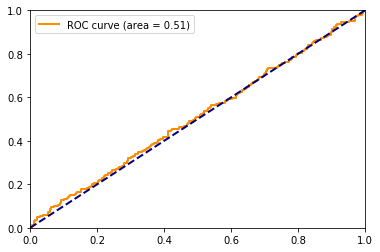

In [11]:
con_mat = metrics.confusion_matrix(y_test, predicted)#精确率Precision=a/(a+c)=TP/(TP+FP),召回率recall=a/(a+b)=TP/(TP+FN),
                                                  #准确率accuracy=(a+d)/(a+b+c+d)=(TP+FN+FP+TN)    
con_mat_df = pd.DataFrame(con_mat,index =['Predicted Positive','Predicted Negative'],columns = ['Actual Positive','Actual Negative'])
print(con_mat_df)

print('---------------------------------------------------------')
mat_df = metrics.classification_report(y_test, predicted)
print(mat_df)
print('---------------------------------------------------------')
print("accuracy:",model.score(X_test,y_test))

cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)

print("cross_val:",cross_val)
print("cross_val.mean():",cross_val.mean())
# scores = model.predict_proba(X_test)[:,1]


fpr = dict()
tpr = dict()
roc_auc = dict()

scores= model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

print("roc_auc:",roc_auc)

### Strategy

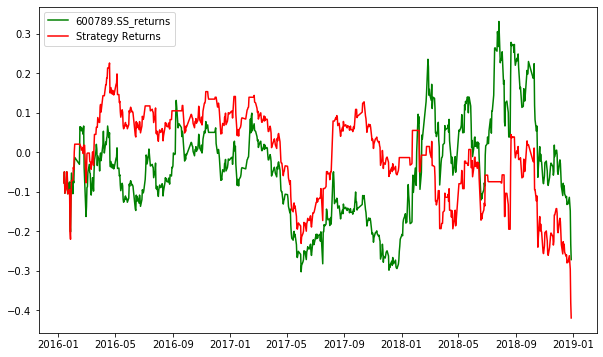

In [12]:
underlying_col = underlying + '_returns'
data['Predicted_Signal'] = 0

# data['Predicted_Signal'] = model.predict(X)  #预测的是明天的涨跌情况
data['Predicted_Signal'] = np.where(model.predict(X)==-1, 0 ,1)

data[underlying_col] = np.log(data['Close']/data['Close'].shift(1))  #今天/昨天 今天的return
Cumulative_underlying_returns = np.cumsum(data[split:][underlying_col])

data['Startegy_returns'] =data[underlying_col]* data['Predicted_Signal'].shift(1) #今天的涨跌对应今天的return
Cumulative_Strategy_returns = np.cumsum(data[split:]['Startegy_returns'])
plt.figure(figsize=(10,6))
plt.plot(Cumulative_underlying_returns ,color = 'g',label = underlying_col)
plt.plot(Cumulative_Strategy_returns,color = 'r', label = 'Strategy Returns')
plt.legend()
plt.show()